In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [33]:
df = pd.read_csv("/content/car data.csv")
print(df.shape)
print(df.info())
print(df.head())

(301, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Driven_kms     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Selling_type   301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB
None
  Car_Name  Year  Selling_Price  Present_Price  Driven_kms Fuel_Type  \
0     ritz  2014           3.35           5.59       27000    Petrol   
1      sx4  2013           4.75           9.54       43000    Diesel   
2     ciaz  2017           7.25           9.85        6900    Petrol   
3  wagon r  2011           2.85           4.15 

In [34]:
print(df["Fuel_Type"].value_counts())

Fuel_Type
Petrol    239
Diesel     60
CNG         2
Name: count, dtype: int64


In [35]:
df = df.dropna()

In [36]:
import datetime
current_year = datetime.datetime.now().year

df['Car_Age'] = current_year - df['Year']
df = df.drop(['Car_Name', 'Year'], axis=1)

print(df.head())

   Selling_Price  Present_Price  Driven_kms Fuel_Type Selling_type  \
0           3.35           5.59       27000    Petrol       Dealer   
1           4.75           9.54       43000    Diesel       Dealer   
2           7.25           9.85        6900    Petrol       Dealer   
3           2.85           4.15        5200    Petrol       Dealer   
4           4.60           6.87       42450    Diesel       Dealer   

  Transmission  Owner  Car_Age  
0       Manual      0       11  
1       Manual      0       12  
2       Manual      0        8  
3       Manual      0       14  
4       Manual      0       11  


In [37]:
# # IQR method
Q1 = df['Selling_Price'].quantile(0.25)
Q3 = df['Selling_Price'].quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# # Remove outliers
data_after = df[(df['Selling_Price'] >= lower_limit) &
                         (df['Selling_Price'] <= upper_limit)]

print("Before cleaning shape:", df.shape)
print("After cleaning shape:", data_after.shape)

Before cleaning shape: (301, 8)
After cleaning shape: (284, 8)


In [38]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop="first"), categorical)
    ], remainder="passthrough"
)

# ML pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=200, random_state=42))
])

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Fuel_Type', 'Selling_type',
                                                   'Transmission'])])),
                ('regressor',
                 RandomForestRegressor(n_estimators=200, random_state=42))])

In [44]:
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R² Score:", round(r2, 3))
print("RMSE:", round(rmse, 3))

R² Score: 0.957
RMSE: 0.758


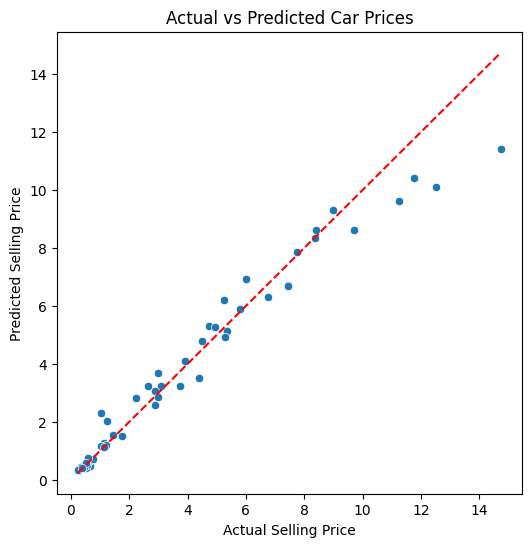

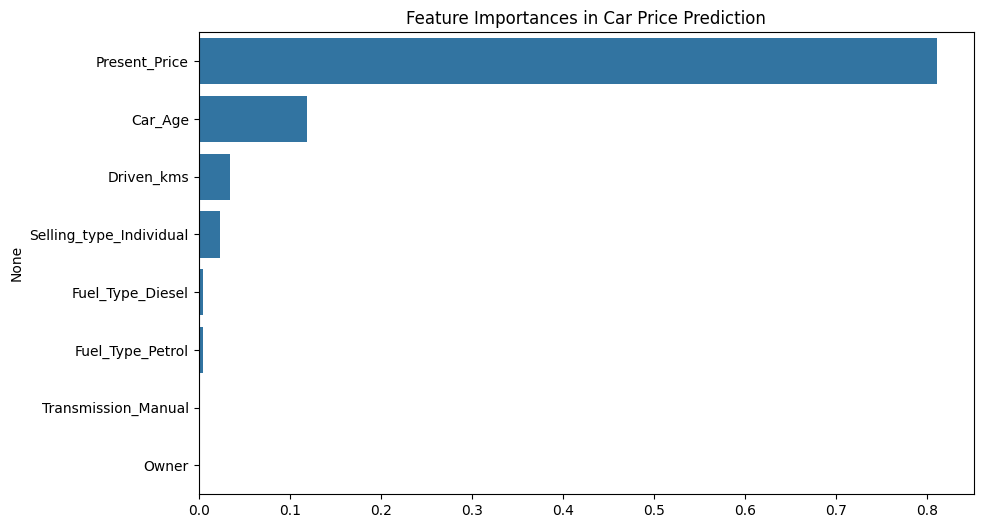

In [41]:
# Actual vs Predicted
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Selling Price")
plt.ylabel("Predicted Selling Price")
plt.title("Actual vs Predicted Car Prices")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.show()

# Feature Importances
rf = model.named_steps['regressor']
enc = model.named_steps['preprocessor'].named_transformers_['cat']
feature_names = enc.get_feature_names_out(categorical)
all_features = list(feature_names) + numeric
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Feature Importances in Car Price Prediction")
plt.show()

In [42]:

import joblib

# Save model
joblib.dump(model, "car_price_model.pkl")

['car_price_model.pkl']